In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold

In [2]:
train_df = pd.read_csv('data/train_features_total.csv')
test_df = pd.read_csv('data/test_features_total.csv')
train_team = pd.read_csv('data/train_team_features.csv')
test_team = pd.read_csv('data/test_team_features.csv')
unique_cols = [c for c in train_team.columns if c not in train_df.columns]
train_X = pd.concat([train_df, train_team[unique_cols]], axis=1)
test_X = pd.concat([test_df, test_team[unique_cols]], axis=1)
df = pd.concat([train_X, test_X])

train_samples, train_features = train_df.shape

In [3]:
df.head()

,chat_len,r_chat_msg,d_chat_msg,r1_chat_msg,r2_chat_msg,r3_chat_msg,r4_chat_msg,r5_chat_msg,d1_chat_msg,d2_chat_msg,...,lh_sum_diff,health_sum_diff,max_health_sum_diff,level_sum_diff,kills_sum_diff,deaths_sum_diff,assists_sum_diff,denies_sum_diff,nearby_creep_death_count_sum_diff,health_frac_sum_diff
0,11,11,0,3,0,3,0,5,0,0,...,-7.0,-848.0,0.0,-4.0,-1.0,1.0,-1.0,-16.0,-34.0,-1.197336
1,10,8,2,0,8,0,0,0,0,0,...,31.0,1867.0,680.0,7.0,15.0,-12.0,11.0,12.0,147.0,0.409786
2,0,0,0,0,0,0,0,0,0,0,...,0.0,-38.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001505
3,4,2,2,0,0,0,2,0,0,0,...,-23.0,230.0,-80.0,4.0,5.0,-5.0,7.0,31.0,37.0,0.431305
4,3,0,3,0,0,0,0,0,2,0,...,-39.0,1121.0,760.0,-1.0,-2.0,2.0,1.0,-11.0,-38.0,-0.366772


In [4]:
del train_df, test_df, train_team, test_team, unique_cols, train_X, test_X

In [5]:
df.shape

(49675, 3243)

In [6]:
variances = np.array([df[c].var() if df[c].dtype != object else -1 for c in df.columns])

In [7]:
zero_var_cols = [c for i, c in enumerate(df.columns) if variances[i] == 0]

In [8]:
df.drop(zero_var_cols, axis=1, inplace=True)
df.shape

(49675, 3195)

In [9]:
cat_cols = [c for c in df.columns if df[c].dtype == object and c not in ['game_mode', 'lobby_type', 'game_phase']]
df.drop(cat_cols, axis=1, inplace=True)  # dropping categorical cols for players

In [10]:
df.shape

(49675, 3155)

In [11]:
df = pd.get_dummies(df, columns=['game_mode', 'lobby_type', 'game_phase'])

In [12]:
df.shape

(49675, 3162)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr().abs()

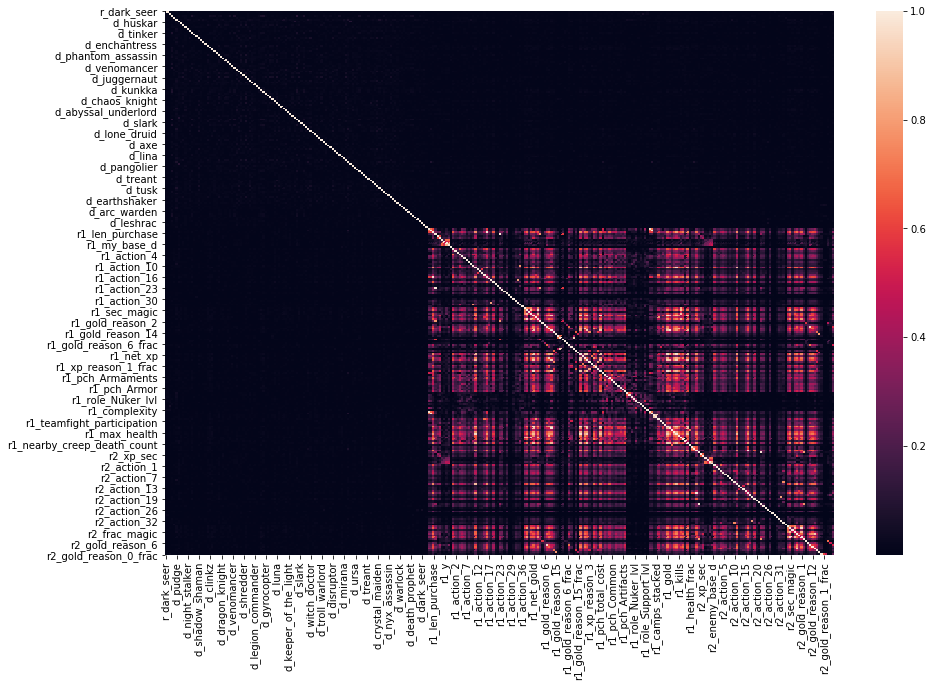

In [58]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr.iloc[500:800, 500:800]);

In [59]:
upper = corr.where(np.triu(np.ones_like(corr), k=1).astype(bool))
corr.shape

(3162, 3162)

In [72]:
threshold = .65
to_drop1 = [c for c in upper.columns if any(upper[c] > threshold)]
to_drop2 = []
for i, c in enumerate(upper.columns):
    correlated = upper[c] > threshold
    cf = upper.columns[correlated]
    for cor_f in cf:
        if cor_f not in to_drop2:
#             print(f"Cor({c}, {cor_f}) > {threshold}")
            to_drop2.append(c)
            break

In [73]:
len(to_drop1), len(to_drop2)

(1584, 1387)

In [75]:
df_decorr = df[[c for c in df.columns if c not in to_drop2]]

In [76]:
df_decorr

,chat_len,r1_chat_msg,r2_chat_msg,r3_chat_msg,r4_chat_msg,r5_chat_msg,d1_chat_msg,d2_chat_msg,d3_chat_msg,d4_chat_msg,...,health_sum_diff,denies_sum_diff,nearby_creep_death_count_sum_diff,game_mode_All Draft,game_mode_Captains Mode,game_mode_Random Draft,game_mode_Single Draft,game_mode_Turbo Mode,lobby_type_Public matchmaking,game_phase_mid_game
0,11,3,0,3,0,5,0,0,0,0,...,-848.0,-16.0,-34.0,1,0,0,0,0,0,0
1,10,0,8,0,0,0,0,0,0,2,...,1867.0,12.0,147.0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,-38.0,0.0,0.0,0,0,0,0,1,1,0
3,4,0,0,0,2,0,0,0,0,2,...,230.0,31.0,37.0,1,0,0,0,0,0,0
4,3,0,0,0,0,0,2,0,0,0,...,1121.0,-11.0,-38.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,0,0,0,0,0,0,0,...,-1264.0,-20.0,3.0,1,0,0,0,0,0,0
9996,9,0,0,1,5,1,1,0,1,0,...,235.0,-5.0,79.0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,-707.0,-6.0,-42.0,1,0,0,0,0,0,0
9998,3,0,0,0,0,0,0,2,0,1,...,-1119.0,21.0,37.0,1,0,0,0,0,0,1


In [78]:
int_cols = []
float_cols = []
unchanged_cols = []
for c in df_decorr.columns:
    ct = str(df_decorr[c].dtype)
    if ct.startswith('int'):
        int_cols.append(c)
    elif ct.startswith('float'):
        float_cols.append(c)
    else:
        unchanged_cols.append(c)

In [79]:
int_cols_dtype_map = df_decorr[int_cols].apply(pd.to_numeric, downcast='integer').dtypes
float_cols_dtype_map = df_decorr[float_cols].apply(pd.to_numeric, downcast='float').dtypes

In [80]:
unchanged_map = df_decorr[unchanged_cols].dtypes

In [81]:
dtype_map = {**int_cols_dtype_map, **float_cols_dtype_map, **unchanged_map}

In [ ]:
dtype_map

In [82]:
import pickle as pcl
with open("dtype_map.pcl", "wb") as f:
    pcl.dump(dtype_map, f)

In [86]:
dtype_map

{'chat_len': dtype('int16'),
 'r1_chat_msg': dtype('int16'),
 'r2_chat_msg': dtype('int8'),
 'r3_chat_msg': dtype('int8'),
 'r4_chat_msg': dtype('int8'),
 'r5_chat_msg': dtype('int8'),
 'd1_chat_msg': dtype('int8'),
 'd2_chat_msg': dtype('int8'),
 'd3_chat_msg': dtype('int8'),
 'd4_chat_msg': dtype('int8'),
 'd5_chat_msg': dtype('int8'),
 'r_tower_killed': dtype('int8'),
 'd_tower_killed': dtype('int8'),
 'd_barracks_killed': dtype('int8'),
 'r_roshan_killed': dtype('int8'),
 'd_roshan_killed': dtype('int8'),
 'r_tower_denied': dtype('int8'),
 'd_tower_denied': dtype('int8'),
 'r_wraith_band': dtype('int8'),
 'r_enchanted_mango': dtype('int8'),
 'r_clarity': dtype('int8'),
 'r_tpscroll': dtype('int8'),
 'r_magic_stick': dtype('int8'),
 'r_wind_lace': dtype('int8'),
 'r_magic_wand': dtype('int8'),
 'r_stout_shield': dtype('int8'),
 'r_quelling_blade': dtype('int8'),
 'r_branches': dtype('int8'),
 'r_faerie_fire': dtype('int8'),
 'r_flask': dtype('int8'),
 'r_orb_of_venom': dtype('int8')

In [83]:
len(dtype_map)

1775

In [84]:
df_decorr.dtypes.value_counts()

int64      1406
float64     361
uint8         7
bool          1
dtype: int64

In [77]:
X_train = df_decorr.iloc[:train_samples, :]
X_test = df_decorr.iloc[train_samples:, :]
X_train.to_csv('features/post_processed_total_train.csv', index=False)
X_test.to_csv('features/pos_processed_total_test.csv', index=False)